In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd

In [13]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [15]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [20]:
# the date 1 year ago from last date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()



('2017-08-23')

In [30]:
# Design a query to retrieve the last 12 months of precipitation data prior to your 
#trips start date and plot the results
yearago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(yearago)
# Perform a query to retrieve the date and prcp values
prcpvalue= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yearago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcpvalue)
df.head()
# Sort the dataframe by date
df.set_index("date").head()
# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


2016-08-23


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


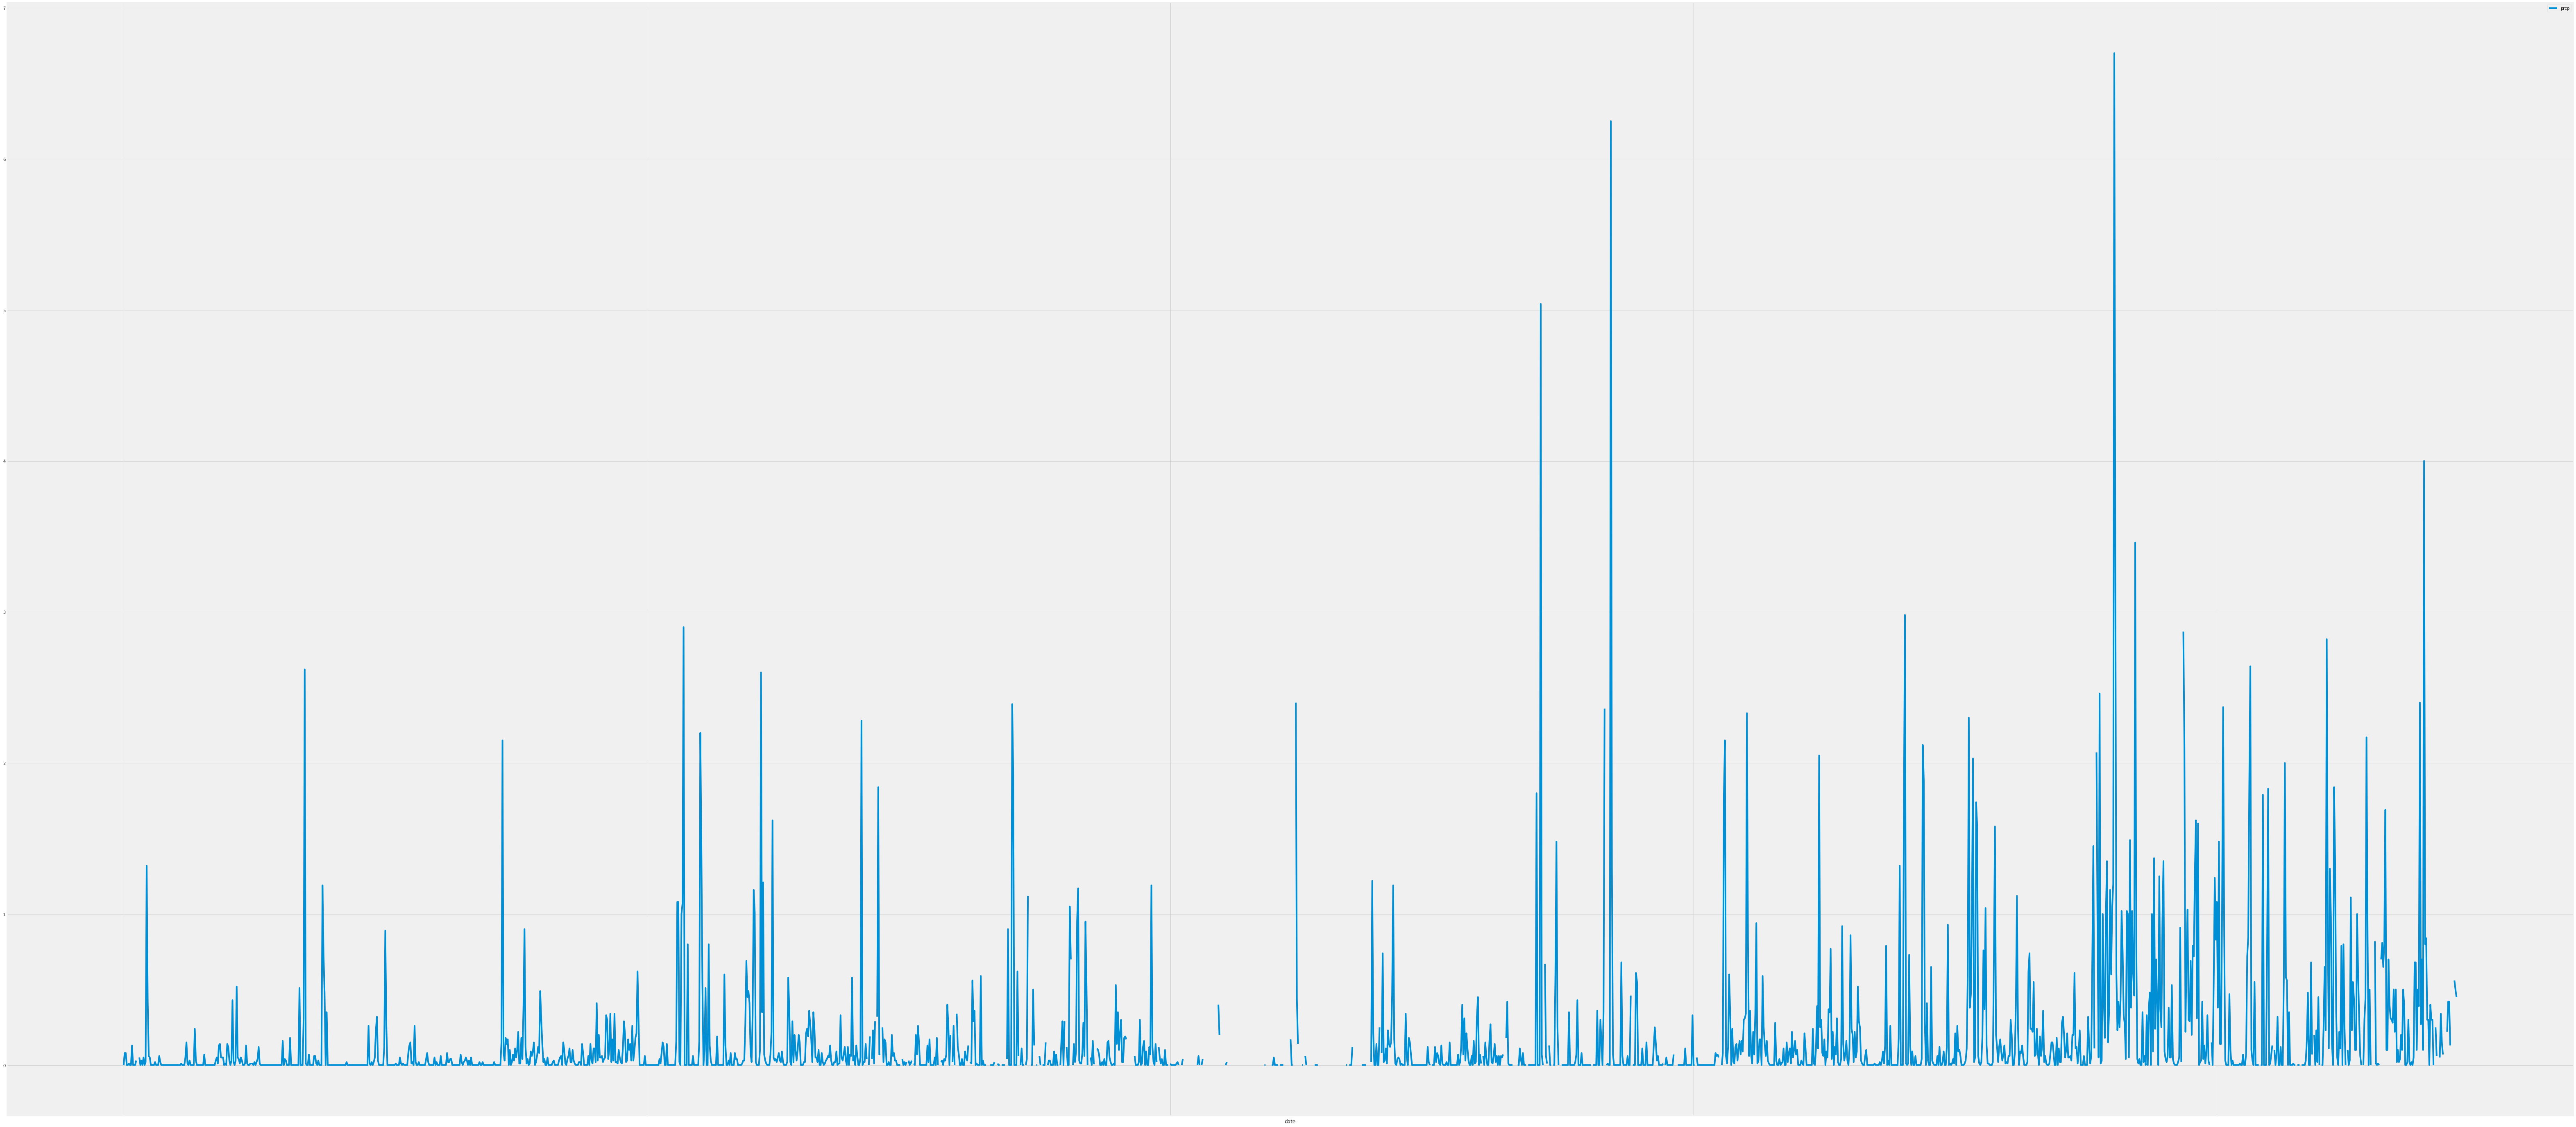

In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.plot('date', 'prcp', figsize=(100,50))

In [41]:
# How many stations are available in this dataset?
totalstations = session.query(Station.station).count()
totalstations

9

In [43]:

# List the stations and the counts in descending order.
activestation= session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
activestation


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# What are the most active stations?
mostactive = activestation[0]
mostactive


('USC00519281', 2772)

In [53]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == mostactive.station).all()

[(54.0, 85.0, 71.66378066378067)]

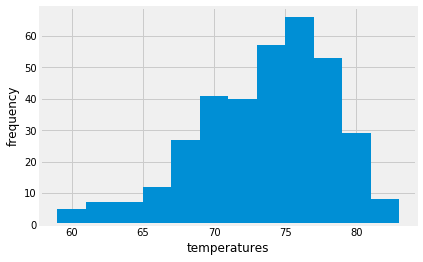

In [65]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data previous to your 
# trips start date for this station and plot the results as a histogram
station_highestTemp = session.query(Measurement.tobs).filter(Measurement.station == mostactive.station). filter(Measurement.date >= yearago).all()
df = pd.DataFrame(station_highestTemp)
plt.hist(df['tobs'],12)
plt.xlabel("temperatures")
plt.ylabel("frequency")
plt.show()


In [66]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [95]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017, 8, 23)
end_date = dt.date(2017,8,27)
Tempcalc = calc_temps (start_date,end_date)
print(Tempcalc) 

[(76.0, 80.25, 82.0)]


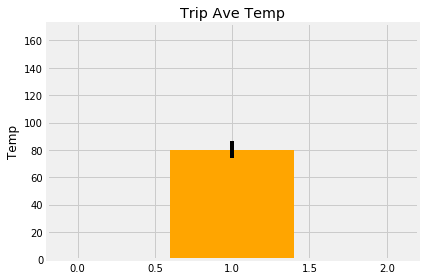

In [108]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tempmin = Tempcalc[0][0]
tempavg = Tempcalc[0][1]
tempmax = Tempcalc[0][2]
diff = tempmax - tempmin

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , tempavg, color= 'orange', yerr= diff)
ax.set_ylabel("Temp")
ax.set_title("Trip Ave Temp")
ax.margins(1,1)
fig.tight_layout()

In [114]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
startdate = dt.date(2016, 8, 23)
enddate = dt.date(2016, 8, 27)

station_trip= session.query(Station.station, Station.name, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).order_by(func.sum(Measurement.prcp).desc()).all()
print(station_trip)

[('USC00519397', 'WAIKIKI 717.2, HI US', -157.8168, 3.0, 117.00000000000033)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
